# Data Preparation, Pipelines & Model 

In [1]:
# Modules importeren
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
import joblib

In [2]:
# Dataset importeren 
df = pd.read_csv("/Users/odessa/Desktop/Applied Data Science & AI/Data Science/Code Inleiding data science/song_data.csv")

In [3]:
print(df['time_signature'].value_counts(dropna=False))

time_signature
4    17754
3      772
5      233
1       73
0        3
Name: count, dtype: int64


In [4]:
df = df[df['time_signature'] > 1]

In [5]:

# Target variabele maken 
target = 'song_popularity'

### Phase 3: Data Preparation

In [6]:
# 2 nummers droppen
#df = df.drop([7119, 11171]).reset_index(drop=True)

In [7]:
print(f"Totaal aantal waardes in de dataframe vóór het verwijderen van dubbele waardes uit song_name en song_duration_ms: {len(df)}")

# Dubbele waardes droppen van song_name en song_duration 
# Als ik alleen song_name duplicates zou verwijderen, zou ik misschien covers van nummers verwijderen, dus daarom check ik ook de song_duration 
df.drop_duplicates(subset=['song_name', 'song_duration_ms'], inplace = True)
print(f"Totaal aantal waardes in de dataframe na verwijderen van dubbele waardes uit song_name en song_duration_ms: {len(df)}")

Totaal aantal waardes in de dataframe vóór het verwijderen van dubbele waardes uit song_name en song_duration_ms: 18759
Totaal aantal waardes in de dataframe na verwijderen van dubbele waardes uit song_name en song_duration_ms: 14402


In [8]:
df.drop(columns=["song_name"], inplace=True) # inplace=True veranderd de originele dataframe zonder nieuwe dataframe te maken 

In [9]:
X = df.drop(columns=[target], axis=1)
y = df[target]

In [10]:
print(X['key'].unique())

[ 8  3  0 10  4  2  1  9  7 11  5  6]


In [11]:
# Zorg dat 'key' en 'time_signature' als categorisch gezien worden
X['time_signature'] = X['time_signature'].astype(str)
X['key'] = X['key'].astype(int)  # blijft numeriek voor de cyclische encoder

## Winsorizer Class

In [12]:
# BaseEstimator zorgt dat sklearn mijn class kan herkennen als model/stap in pipeline.
# TransformerMixin geeft .fit_transform().
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, kolommen): 
        self.kolommen = kolommen 
        self.grenzen_ = None # '_' betekent dat het attribuut pas beschikbaar wordt, nadat fit() is uitgevoerd. 
                             # None, omdat de grenzen nog niet bestaan -- worden berekend bij fit().

    def fit(self, X, y=None):
        """Bereken de onder- en bovengrenzen per kolom met interkwartielafstand-regel."""
        self.grenzen_ = {}
        for kolom in self.kolommen:
            Q1 = X[kolom].quantile(0.25)
            Q3 = X[kolom].quantile(0.75)
            IKR = Q3 - Q1 
            ondergrens = Q1 - 1.5 * IKR
            bovengrens = Q3 + 1.5 * IKR
            self.grenzen_[kolom] = (ondergrens, bovengrens)
        return self 
    
    def transform(self, X):
        """Winsoriseer uitschieters: vervang alle waardes buiten de grenzen met de dichtstbijzijnde grenswaarde."""
        X = X.copy() # kopie maken van data
        for kolom, (ondergrens, bovengrens) in self.grenzen_.items():
            dtype = X[kolom].dtype

            # If the column is integer, cast the thresholds first
            if np.issubdtype(dtype, np.integer):
                ondergrens = int(round(ondergrens))
                bovengrens = int(round(bovengrens))

            X.loc[X[kolom] < ondergrens, kolom] = ondergrens
            X.loc[X[kolom] > bovengrens, kolom] = bovengrens

            # Just to be sure, cast back to the original dtype
            X[kolom] = X[kolom].astype(dtype)
        return X
    
    def get_feature_names_out(self, input_features=None):
        """Zorg dat de kolomnamen behouden blijven in de pipeline."""
        return np.array(self.kolommen)

## Key Cyclic Encoder class 

In [13]:
class ToonsoortCyclischeEncoder(BaseEstimator, TransformerMixin):
    """
    Cyclisch encoden van de toonsoort/key (0-11) met sinus en cosinus. 
    """

    def __init__(self, kolom='key', max_waarde=12):
        self.kolom = kolom
        self.max_waarde = max_waarde
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X):
        X = X.copy()
        k = X[self.kolom]
        X[f'{self.kolom}_sin'] = np.sin(2 * np.pi * k/self.max_waarde)
        X[f'{self.kolom}_cos'] = np.cos(2 * np.pi * k/self.max_waarde)
        return X.drop(columns=[self.kolom])
    
    def get_feature_names_out(self, input_features=None):
        return np.array([f'{self.kolom}_sin', f'{self.kolom}_cos'])

In [14]:
def get_feature_names_from_column_transformer(ct):
    """Haalt feature names uit een ColumnTransformer, ook als nested pipelines aanwezig zijn."""
    output_features = []

    for name, transformer, cols in ct.transformers_:
        if transformer == 'drop':
            continue
        elif transformer == 'passthrough':
            output_features.extend(cols)
        elif hasattr(transformer, 'get_feature_names_out'):
            try:
                names = transformer.get_feature_names_out(cols)
                output_features.extend(names)
            except:
                output_features.extend(cols)
        elif hasattr(transformer, 'transformers_'):  # nested ColumnTransformer
            output_features.extend(get_feature_names_from_column_transformer(transformer))
        elif isinstance(transformer, Pipeline):
            last_step = transformer.steps[-1][1]
            if hasattr(last_step, 'get_feature_names_out'):
                try:
                    names = last_step.get_feature_names_out(cols)
                    output_features.extend(names)
                except:
                    output_features.extend(cols)
            else:
                output_features.extend(cols)
        else:
            output_features.extend(cols)
    return output_features

### Phase 4: Modeling 

Supervised learning, omdat je de uitkomst al hebt 
<br>
Supervised learning heeft 2 hoofdtakken: regressie en classificatie 
<br>
RMSE 
<br>
Meervoudige lineare regressie 
<br>
Logistieke lineare regressie is classification 
<br>
Random forests is het begin van dat machine learning slim werd 

In [15]:
def nieuwe_features(df):
    df = df.copy()

    # Replace NaN or infinite values in loudness before using it
    df['loudness'] = df['loudness'].replace([np.inf, -np.inf], np.nan).fillna(df['loudness'].median())

    df['energy_dance'] = df['energy'] * df['danceability']
    df['tempo_loudness'] = df['tempo'] * df['loudness']
    df['valence_dance'] = df['audio_valence'] * df['danceability']

    #Ratio featurres
    df['acoustic_dance_ratio'] = df['acousticness'] / (df['danceability'] + 0.001)
    df['duration_energy_ratio'] = df['song_duration_ms'] / (df['energy'] + 0.001)

    # Replace any infinities that could appear from division
    df['tempo_loudness'] = df['tempo_loudness'].clip(lower=-0.99)  # no log1p negatives
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    return df
feature_engineering = FunctionTransformer(nieuwe_features, validate=False)


In [16]:
# Kolommen indelen
kolommen_winsoriseren = ['song_duration_ms', 'tempo']
categorische_kolommen = ['time_signature', 'audio_mode']
cyclische_kolommen = ['key']
engineered_features = [
    'energy_dance', 'tempo_loudness', 'valence_dance',
    'acoustic_dance_ratio', 'duration_energy_ratio'
]

# Alle numerieke kolommen behalve target
numerieke_kolommen = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Alle numerieke kolommen behalve target
overige_kolommen = [
    c for c in numerieke_kolommen
    if c not in kolommen_winsoriseren + cyclische_kolommen + categorische_kolommen
]

In [17]:
# Train en test set maken 
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state = 42
)

In [18]:
print("Numeriek:", numerieke_kolommen)
print("Overige:", overige_kolommen)

Numeriek: ['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode', 'speechiness', 'tempo', 'audio_valence']
Overige: ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'audio_valence']


In [19]:
skewed_cols = ['acousticness', 'instrumentalness', 'liveness', 'loudness', 'speechiness']

In [20]:
print("NaNs in loudness before pipeline:", X_train['loudness'].isna().sum())
print("Infs in loudness before pipeline:", np.isinf(X_train['loudness']).sum())
print("Loudness min/max:", X_train['loudness'].min(), X_train['loudness'].max())


NaNs in loudness before pipeline: 0
Infs in loudness before pipeline: 0
Loudness min/max: -36.729 1.585


## Preprocessors

In [21]:
# Preprocessor voor Lineaire Regressie
preprocessor = ColumnTransformer([
    # 1. outliers winsoriseren 
    ('winsor_scale', Pipeline([
        ('winsor', Winsorizer(kolommen=kolommen_winsoriseren)),
        ('scaler', StandardScaler())
    ]), kolommen_winsoriseren),

    # 2. yeo-johnson transform
    ('transform_scale', Pipeline([
        ('power', PowerTransformer(method='yeo-johnson')),
        ('scaler', StandardScaler())
    ]), ['danceability', 'audio_valence', 'energy']),

    # 3. Log1p transform 
    ('log_scale', Pipeline([
        ('log', FunctionTransformer(np.log1p, validate=False)),
        ('scaler', StandardScaler())
    ]), ['acoustic_dance_ratio', 'duration_energy_ratio', 'tempo_loudness']),

    # 4. One-hot encoder
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorische_kolommen),

    # 5. Cyclisch encoden Key 
    ('key_cyclisch', Pipeline([
        ('encoder', ToonsoortCyclischeEncoder(kolom='key', max_waarde=12)),
        ('scaler', StandardScaler())
    ]), cyclische_kolommen),

    # 6. Overige numerieke waardes scalen 
    ('scale_rest', StandardScaler(), 
      [c for c in overige_kolommen 
        if c not in ['danceability', 'audio_valence', 'energy', 'loudness']] 
        + ['energy_dance', 'valence_dance'])
],
remainder='drop')

In [22]:
# Preprocessor voor Random Forest
preprocessor_rf = ColumnTransformer([
    ('winsor', Winsorizer(kolommen=kolommen_winsoriseren), kolommen_winsoriseren),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorische_kolommen),
    ('key_cyclisch', ToonsoortCyclischeEncoder(kolom='key', max_waarde=12), cyclische_kolommen)
], remainder='passthrough')

## Pipelines

In [23]:
# Lineaire Regressie pipeline 
lineair_pipeline = Pipeline([
    ('feature_creation', feature_engineering),
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])

In [24]:
# Random forest pipeline
random_forest_pipeline = Pipeline([
    ('feature_creation', feature_engineering),
    ('preprocess', preprocessor_rf),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

In [25]:
# Trainen en evalueren 
lineair_pipeline.fit(X_train, y_train)
y_pred = lineair_pipeline.predict(X_test)

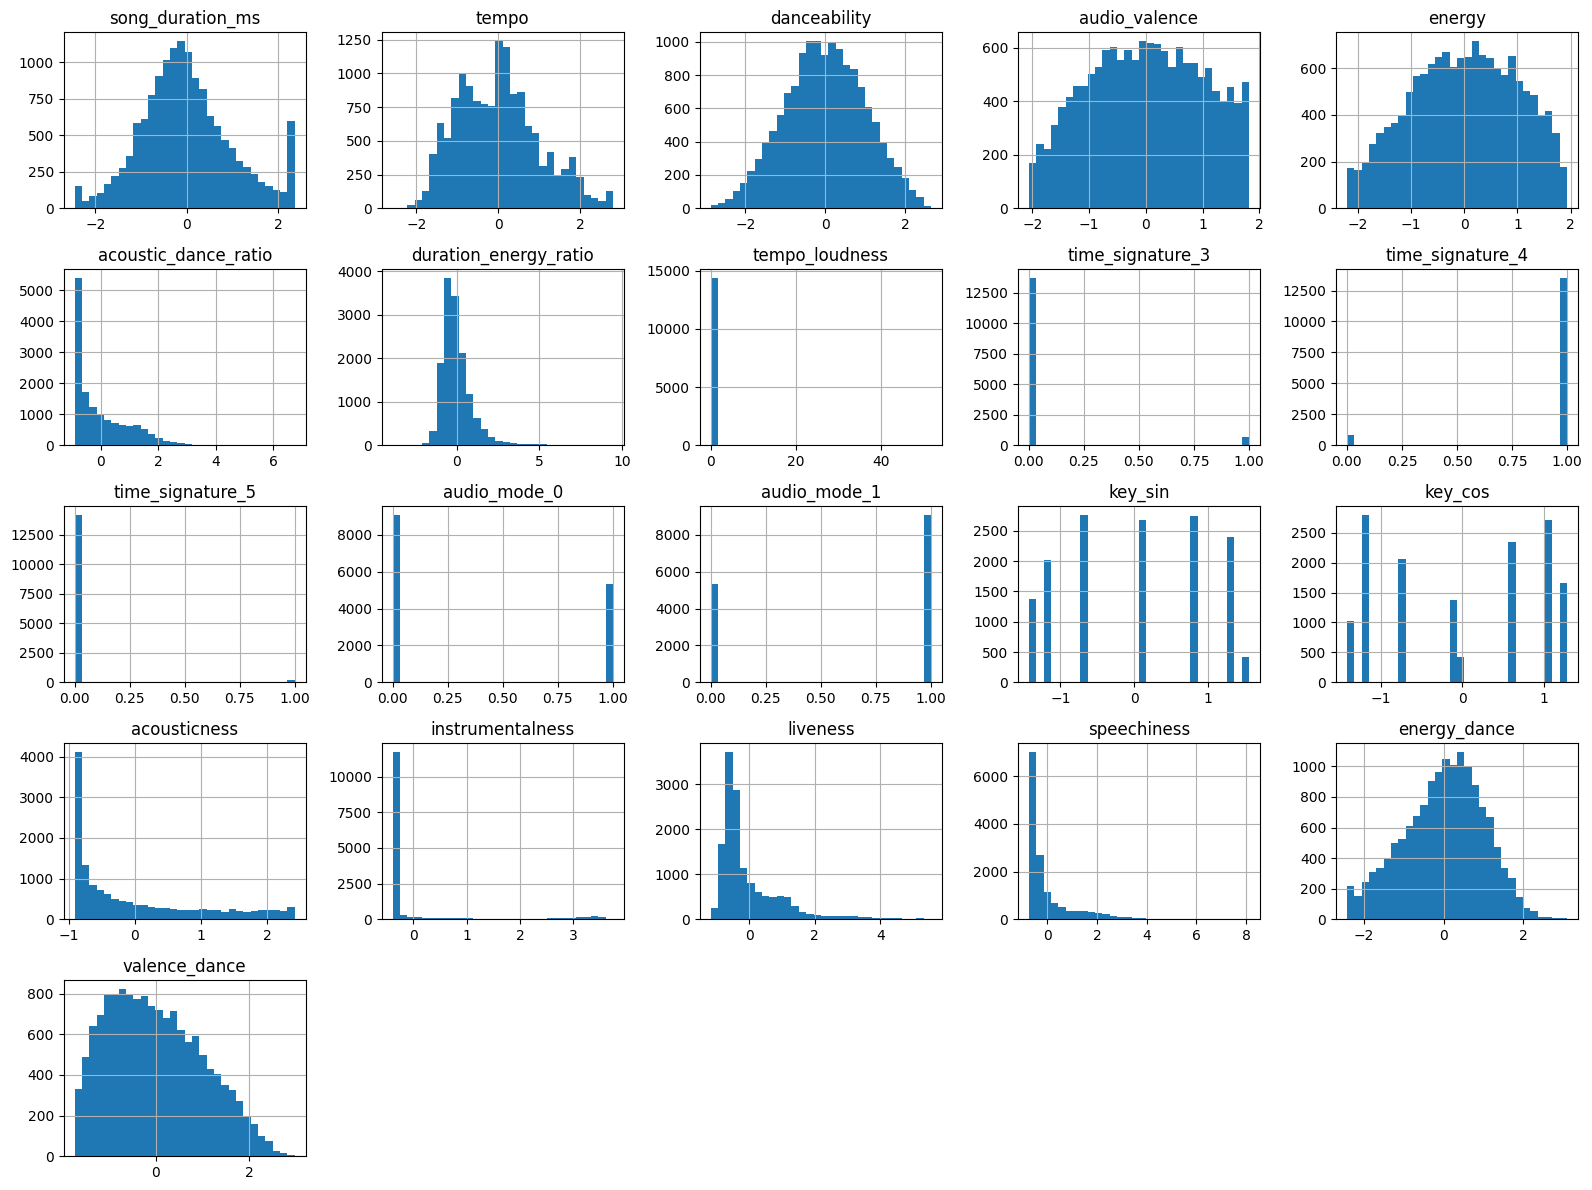

In [26]:
# Apply only preprocessing (exclude model)
X_transformed = lineair_pipeline[:-1].fit_transform(X)

# Get all feature names robustly
feature_names = get_feature_names_from_column_transformer(
    lineair_pipeline.named_steps['preprocess']
)

# Make DataFrame
df_transformed = pd.DataFrame(X_transformed, columns=feature_names)

# Plot histograms
df_transformed.hist(figsize=(16, 12), bins=30)
plt.tight_layout()
plt.show()

## Fase 1: RandomizedSearchCV

In [27]:
# Broad parameter ranges
param_dist = {
    'model__n_estimators': randint(100, 400),
    'model__max_depth': randint(4, 16),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5)
}

random_search = RandomizedSearchCV(
    estimator=random_forest_pipeline,
    param_distributions=param_dist,
    n_iter=25,          # number of random combinations to test
    scoring='r2',
    cv=3,               # fewer folds = faster
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search.fit(X_train, y_train)

print("Best parameters (random search):", random_search.best_params_)
print("Best CV R²:", random_search.best_score_)

# (Optional) Save for later
import joblib
joblib.dump(random_search, "random_search_rf.pkl")

# Store the best params for grid refinement
best = random_search.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END model__max_depth=14, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=120; total time=  16.0s
[CV] END model__max_depth=14, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=120; total time=  16.0s
[CV] END model__max_depth=14, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=120; total time=  16.1s
[CV] END model__max_depth=14, model__min_samples_leaf=3, model__min_samples_split=9, model__n_estimators=199; total time=  28.8s
[CV] END model__max_depth=14, model__min_samples_leaf=3, model__min_samples_split=9, model__n_estimators=199; total time=  28.9s
[CV] END model__max_depth=14, model__min_samples_leaf=3, model__min_samples_split=9, model__n_estimators=199; total time=  29.7s
[CV] END model__max_depth=11, model__min_samples_leaf=4, model__min_samples_split=4, model__n_estimators=249; total time=  31.2s
[CV] END model__max_depth=11, model_

#### RandomizedSearch

Best parameters (random search): {'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 6, 'model__n_estimators': 370}
<br>
max_depth = 10  
<br>
min_samples_leaf = 4  
<br>
min_samples_split = 6  
<br>
n_estimators = 370
<br>

Best CV R²: 0.05542467259398683


Best parameters (random search): {'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 6, 'model__n_estimators': 370}
Best CV R²: 0.05542467259398683

## Fase 2: GridSearchCV 

In [28]:
# Define a tighter grid around the best RandomizedSearchCV result
param_grid = {
    'model__n_estimators': [best['model__n_estimators'] - 50,
                            best['model__n_estimators'],
                            best['model__n_estimators'] + 50],
    'model__max_depth': [best['model__max_depth'] - 2,
                         best['model__max_depth'],
                         best['model__max_depth'] + 2],
    'model__min_samples_split': [best['model__min_samples_split'] - 1,
                                 best['model__min_samples_split'],
                                 best['model__min_samples_split'] + 1],
    'model__min_samples_leaf': [best['model__min_samples_leaf'] - 1,
                                best['model__min_samples_leaf'],
                                best['model__min_samples_leaf'] + 1]
}

# Remove invalid (≤ 0) values
for key, vals in param_grid.items():
    param_grid[key] = [v for v in vals if v > 0]

# Define grid search
grid_search = GridSearchCV(
    estimator=random_forest_pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best parameters (grid refinement):", grid_search.best_params_)
print("Cross-val R²:", grid_search.best_score_)

# Save the trained grid search for later use
import joblib
joblib.dump(grid_search, "grid_search_rf.pkl")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__min_samples_split=7, model__n_estimators=323; total time=  27.0s
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__min_samples_split=7, model__n_estimators=323; total time=  27.4s
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__min_samples_split=7, model__n_estimators=323; total time=  27.4s
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__min_samples_split=7, model__n_estimators=323; total time=  27.4s
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__min_samples_split=7, model__n_estimators=323; total time=  27.5s
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=323; total time=  29.2s
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__min_samples_split=7, model__n_estimators=373; total time=  31.1s
[CV] END model__max_depth=6, model__min_sa

['grid_search_rf.pkl']

#### Gridsearch

Best parameters (grid refinement): {'model__max_depth': 10, 'model__min_samples_leaf': 3, 'model__min_samples_split': 7, 'model__n_estimators': 370}
<br>
max_depth = 10  
<br>
min_samples_leaf = 3  
<br>
min_samples_split = 7  
<br>
n_estimators = 370

<br>
Cross-val R²: 0.05775448946909154

In [29]:
grid_search = joblib.load("grid_search_rf.pkl")

## Evaluatie test data

In [30]:
beste_model = grid_search.best_estimator_
y_pred_rf = beste_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)

print(f"Test R²: {r2_rf:.4f}")
print(f"Test RMSE: {rmse_rf:.4f}")

Test R²: 0.0702
Test RMSE: 19.3635


## Resultaten vergelijken

In [31]:
y_pred_lin = lineair_pipeline.predict(X_test)
r2_lin = r2_score(y_test, y_pred_lin)
rmse_lin = root_mean_squared_error(y_test, y_pred_lin)

resultaten = pd.DataFrame({
    'Model': ['Lineaire regressie', 'Random Forest'],
    'R2': [r2_lin, r2_rf],
    'RMSE': [rmse_lin, rmse_rf]
}).round({'R2': 4, 'RMSE': 2})

display(resultaten)

,Model,R2,RMSE
0,Lineaire regressie,0.0331,19.75
1,Random Forest,0.0702,19.36


### Observaties resultaten 

Random forest presteert beter dan lineare regressie: R² iets omhoog en RMSE iets omlaag. 
<br>
RMSE van 20 is logisch, omdat je populariteit niet alleen op basis van audio features kunt voorspellen. 

### Feature Importances

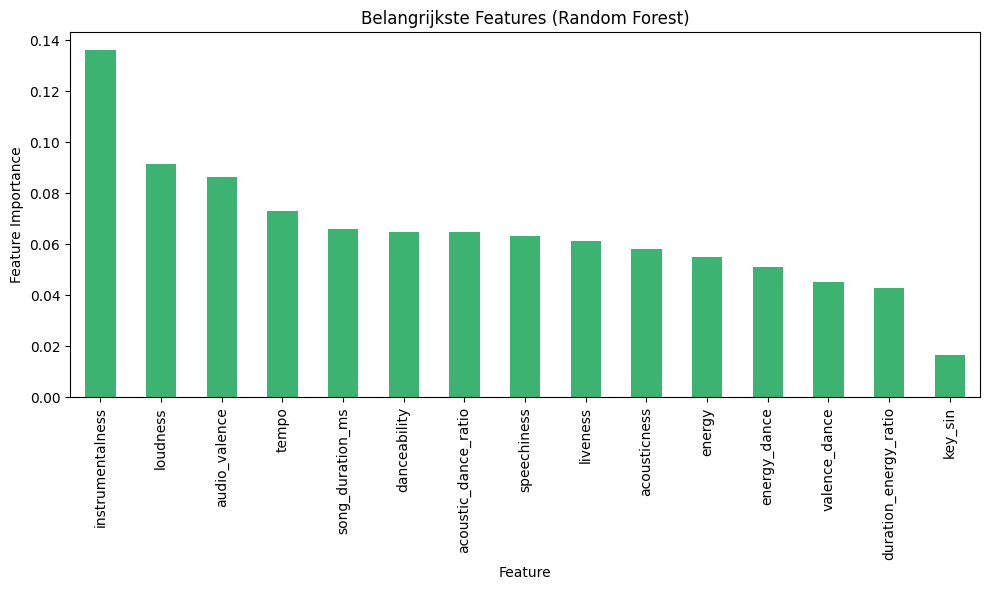

In [32]:
model = grid_search.best_estimator_.named_steps['model']
importances = model.feature_importances_

# Use helper to get feature names
preprocessor = grid_search.best_estimator_.named_steps['preprocess']
feature_names = get_feature_names_from_column_transformer(preprocessor)

# Create series and sort 
feat_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

#Plot top 15 belangrijke features

plt.figure(figsize=(10, 6))
feat_importance.head(15).plot(kind='bar', color='mediumseagreen')
plt.title("Belangrijkste Features (Random Forest)")
plt.ylabel("Feature Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

In [33]:
print(feat_importance.to_string())

instrumentalness         0.136209
loudness                 0.091524
audio_valence            0.086505
tempo                    0.073135
song_duration_ms         0.066017
danceability             0.064945
acoustic_dance_ratio     0.064878
speechiness              0.063159
liveness                 0.061211
acousticness             0.058068
energy                   0.055054
energy_dance             0.051059
valence_dance            0.045123
duration_energy_ratio    0.042794
key_sin                  0.016784
key_cos                  0.014188
audio_mode_0             0.002262
audio_mode_1             0.002194
time_signature_4         0.002174
time_signature_3         0.001543
time_signature_5         0.001173
tempo_loudness           0.000000
